In [1]:
print('Initializing data engineering!')
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import json, requests, gzip, folium

Initializing data engineering!


### Brazil data engineering

In [2]:
url = 'https://data.brasil.io/dataset/covid19/caso.csv.gz'
response = requests.get(url)
# response.content
with open('/home/rafael/tmp/caso.csv.gz', 'wb') as f:
    f.write(response.content)

In [3]:
with gzip.open('/home/rafael/tmp/caso.csv.gz') as f:
    df = pd.read_csv(f)

In [4]:
df.rename(columns={'confirmed': 'cases', 'estimated_population_2019':'population', 'order_for_place':'day'}, inplace= True)
df['date'] = df['date'].astype('datetime64[ns]')

df = df[(df['city']!='Importados/Indefinidos')]

#apenas cidades de SP e por estados
# df = df[((df['state']=='SP') & (df['place_type']=='city')) | (df['place_type']=='state')  ]
df = df[(df['place_type']=='state')]

df.population.fillna(0, inplace=True)
df.city_ibge_code.fillna(0, inplace=True)

df.population = df.population.astype('int')
df.city_ibge_code = df.city_ibge_code.astype('int')

df.drop(columns=['confirmed_per_100k_inhabitants'], inplace=True)
df.fillna('-', inplace=True)

df.sort_values(['state','city','date'], inplace = True)
df.reset_index(inplace = True, drop=True)


# df['week'] = df.date.dt.isocalendar().week 
df['year'] = df.date.dt.year
df['yearMonth'] = df.date.map(lambda x: x.strftime('%Y-%m'))
df['yearWeek'] = df.date.map(lambda x: x.strftime('%y-%V'))
df['diasMes'] = df.date.dt.days_in_month
# df['week'] = np.arange(len(df['yearWeek']))


In [5]:
df.tail()

,date,state,city,place_type,cases,deaths,day,is_last,population,estimated_population,city_ibge_code,death_rate,year,yearMonth,yearWeek,diasMes
18257,2022-01-24,TO,-,state,257971,3986,643,False,1572866,1590248.0,17,0.0155,2022,2022-01,22-04,31
18258,2022-01-25,TO,-,state,260332,3986,644,False,1572866,1590248.0,17,0.0153,2022,2022-01,22-04,31
18259,2022-01-26,TO,-,state,262540,3989,645,False,1572866,1590248.0,17,0.0152,2022,2022-01,22-04,31
18260,2022-01-27,TO,-,state,264904,3993,646,False,1572866,1590248.0,17,0.0151,2022,2022-01,22-04,31
18261,2022-01-28,TO,-,state,267537,3997,647,True,1572866,1590248.0,17,0.0149,2022,2022-01,22-04,31


In [6]:
ultimaData = df.date.max()
hoje = datetime.datetime.now()
offset = 0 if (ultimaData.date() == hoje.date()) else 1
df.loc[df['yearMonth']==str(ultimaData.year) + '-' + '{:02d}'.format(ultimaData.month), 'diasMes'] = hoje.day - offset
hoje.day - offset

29

#### Feature engineering - por semana

In [7]:
print('Iniciando feature engieering Brasil')
inicio = datetime.datetime.now()

states = df.state.unique()
# states = ['SP']
df.drop(df[df['cases'] == 0 ].index, axis=0, inplace= True)

df['perc_death'] = (df['deaths']/df['cases'] * 100).round(2)
df.rename(columns={'order_for_place': 'day'}, inplace= True)

for state in states:
    cities = df[df['state']==state].city.unique()
#     cities = ['Santa Gertrudes']
#     print(datetime.datetime.now().time(), state)
    for city in cities:
        indexes = (df['state']==state) & (df.city == city)
        # valores diários
        df.loc[indexes, 'case_day'] = df[indexes]['cases'].diff()    
        df.loc[indexes, 'death_day'] = df[indexes]['deaths'].diff()

        # Igualo o valor da primeira linha igual ao primeiro número do acumulado, pois se o acumulado começa em 1 o primeiro diff fica igual a 0
        df.loc[(indexes) & (df.day == 1), 'case_day']= df.loc[(indexes) & (df.day==1), 'cases']
        df.loc[(indexes) & (df.day == 1), 'death_day']= df.loc[(indexes) & (df.day==1), 'deaths']

        # Buscando a população do estado/cidade e calculado os indicador per milhar
        if not df[indexes].population.empty:
            thousand = df[indexes]['population'] / 1000
            cases_thousand = (df[indexes]['cases'] / thousand)
            deaths_thousand = (df[indexes]['deaths'] / thousand)
            case_day_thousand = (df[indexes]['case_day'] / thousand)
            death_day_thousand = (df[indexes]['death_day'] / thousand)
        else:
            cases_thousand = 0
            deaths_thousand = 0
            case_day_thousand = 0
            death_day_thousand = 0
            
        df.loc[indexes, 'cases_thousand'] = cases_thousand
        df.loc[indexes, 'deaths_thousand'] = deaths_thousand
        df.loc[indexes, 'case_day_thousand'] = case_day_thousand
        df.loc[indexes, 'death_day_thousand'] = death_day_thousand
        
        df.loc[indexes, 'avg7_deaths'] = df[indexes]['death_day'].rolling(window=7).mean()
#         df.loc[indexes, 'avg7_death_day_thousand'] = df[indexes]['death_day_thousand'].rolling(window=7).mean()

#         df.loc[indexes, 'death_day_medio']= df[indexes]['death_day'].expanding().mean()


df.fillna(0, inplace=True)

df['case_day'] = df['case_day'].astype('int')
df['death_day'] = df['death_day'].astype('int')


df['cases_thousand'] = df['cases_thousand'].round(3)
df['deaths_thousand'] = df['deaths_thousand'].round(3)
df['case_day_thousand'] = df['case_day_thousand'].round(3)
df['death_day_thousand'] = df['death_day_thousand'].round(3)


df['cases'] = df['case_day']
df['deaths'] = df['death_day']


termino = datetime.datetime.now()
print('finalizado em ', termino-inicio)
#df[indexes].tail()

Iniciando feature engieering Brasil
finalizado em  0:00:00.214935


In [19]:
# df2 =  df.groupby(['state','city','yearMonth'], sort=True).agg({
# df2 =  df.groupby(['week'], sort=True).agg({

dados = df.copy()
# dados = df.loc[(df['state']=='SP') & (df['place_type']=='state')]
# dados = df.loc[(df['state']=='AM') & (df ['place_type']=='state')]
# dados = df.loc[(df['city']=='São Paulo') & (df ['place_type']=='city')]
# dados = df.loc[(df['city']=='Lucélia') & (df ['place_type']=='city')]

df2 =  dados.groupby(['yearMonth'], sort=True).agg({
        'cases':'sum', 
        'deaths': 'sum',
        'case_day':'mean',
        'death_day': 'mean',
        'case_day_thousand':'mean',
        'death_day_thousand':'mean',
        'cases_thousand':'mean',
        'deaths_thousand':'mean',
        'diasMes':'mean',
})

df_estados =  dados.groupby(['yearMonth','state'], sort=True).agg({
        'cases':'sum', 
        'deaths': 'sum',
        'case_day':'mean',
        'death_day': 'mean',
        'case_day_thousand':'mean',
        'death_day_thousand':'mean',
        'cases_thousand':'sum',
        'deaths_thousand':'mean',
        'diasMes':'mean',
        'city_ibge_code':'mean',
        'population':'mean'
})

df3 =  dados.groupby(['yearWeek'], sort=True).agg({
        'cases':'sum', 
        'deaths': 'sum',
        'case_day':'mean',
        'death_day': 'mean',
        'case_day_thousand':'mean',
        'death_day_thousand':'mean',
        'cases_thousand':'mean',
        'deaths_thousand':'mean',
        'diasMes':'mean',
})

df3.reset_index(drop=True, inplace=True) #só para ficar com uma lista de números incrementais
df3.head()

df_estados.tail()

cases  deaths      case_day  death_day  case_day_thousand  \
yearMonth state                                                               
2022-01   RS     307081     409  12795.041667  17.041667           1.124500   
          SC     192211     356   6627.965517  12.275862           0.925069   
          SE      11768      32    405.793103   1.103448           0.176517   
          SP     182252    2612   6284.551724  90.068966           0.136897   
          TO      31979      58   1332.458333   2.416667           0.847125   

                 death_day_thousand  cases_thousand  deaths_thousand  diasMes  \
yearMonth state                                                                 
2022-01   RS               0.001417        3426.814         3.215375     29.0   
          SC               0.001862        5308.292         2.833241     29.0   
          SE               0.000276        3549.078         2.639379     29.0   
          SP               0.002000        2851.403         3.395966     29.0   
          TO               0.001583        3773.169         2.522875     29.0   

                 city_ibge_code  population  
yearMonth state                              
2022-01   RS               43.0  11377239.0  
          SC               42.0   7164788.0  
          SE               28.0   2298696.0  
          SP               35.0  45919049.0  
          TO               17.0   1572866.0

In [20]:
df.city.unique()

array(['-'], dtype=object)

In [28]:
df2['cases_mean']= df2.cases.expanding().mean()
df2['case_thousand_mean']= df2.cases_thousand.expanding().mean()
df2['case_day'] = df2['cases']/df2['diasMes']
df2['case_day_mean']= df2.case_day.expanding().mean()
df2['death_day_mean']= df2.case_day.expanding().mean()
df2['deaths/cases_day_mean']= df2['death_day_mean'] / df2['case_day_mean']
df2['deaths/cases']= df2['death_day'] / df2['case_day']

df2['perc_var_cases'] = (((df2['case_day'] - df2['case_day'].shift()) / df2['case_day'].shift())*100).replace([np.inf, -np.inf], 0).replace([np.nan], 0).round(0)


df_estados['cases_mean']= df_estados.cases.expanding().mean()
df_estados['cases_thousand']= (df_estados.cases / (df_estados.population / 1000))#.round(3)
# df_estados['case_thousand_mean']= df_estados.cases_thousand.expanding().mean()
# df_estados['case_day'] = df_estados['cases']/df_estados['diasMes']
# df_estados['case_day_mean']= df_estados.case_day.expanding().mean()

df3['cases_mean']= df3.cases.expanding().mean()
df3['case_thousand_mean']= df3.cases_thousand.expanding().mean()
# df3['case_day_mean']= df3.case_day.expanding().mean()
df3['case_day_thousand_mean']= df3.case_day_thousand.expanding().mean()
df3['case_day_mean'] = df3['cases']/7
# df3['avg7_cases'] = df3['case_day'].rolling(window=7).mean()


df2.tail()

,cases,deaths,case_day,death_day,case_day_thousand,death_day_thousand,cases_thousand,deaths_thousand,diasMes,deaths/cases,cases_mean,case_thousand_mean,case_day_mean,deaths/cases_day_mean,perc_var_cases,death_day_mean
yearMonth,,,,,,,,,,,,,,,,
2021-09,647166,16269,21572.200000,20.285536,0.091784,0.002050,115.097486,2.718723,30.0,0.000940,1.071618e+06,48.440165,35191.646455,1.0,-23.0,35191.646455
2021-10,382263,11049,12331.064516,13.457978,0.065814,0.001434,117.013006,2.768769,31.0,0.001091,1.038792e+06,51.705539,34103.047315,1.0,-43.0,34103.047315
2021-11,285533,6904,9517.766667,8.783715,0.054929,0.000953,118.402496,2.800828,30.0,0.000923,1.004553e+06,54.737218,32985.534558,1.0,-23.0,32985.534558
2021-12,191941,4350,6191.645161,5.991736,0.044220,0.000726,117.855773,2.788595,31.0,0.000968,9.692217e+05,57.481503,31820.582846,1.0,-35.0,31820.582846
2022-01,2964099,7535,102210.310345,10.073529,0.577658,0.001150,125.144422,2.846615,29.0,0.000099,1.052342e+06,60.300792,34753.488158,1.0,1551.0,34753.488158


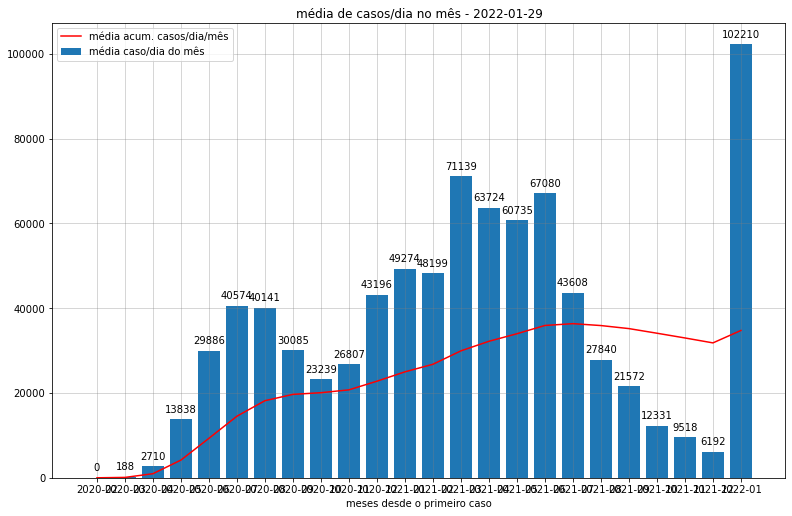

In [26]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(20, 20))
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig, ((ax2)) = plt.subplots(1,1, figsize=(12, 8))
fig.tight_layout(pad=5.0)

ax2.set_title("média de casos/dia no mês - " + str(df.date.max().date()))
ax2.set_xlabel("meses desde o primeiro caso")
ax2.grid(color='gray', alpha = 0.4)

ax2.bar(df2.index, df2.case_day, label='média caso/dia do mês')
#ax2.bar(df2.index, df2.death_day, label='média caso/dia do mês')
ax2.plot(df2.index, df2['case_day_mean'],  label='média acum. casos/dia/mês', color='red')

for p in ax2.patches:
    ax2.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
ax2.legend()
fig.savefig('../analysis/temp.png')

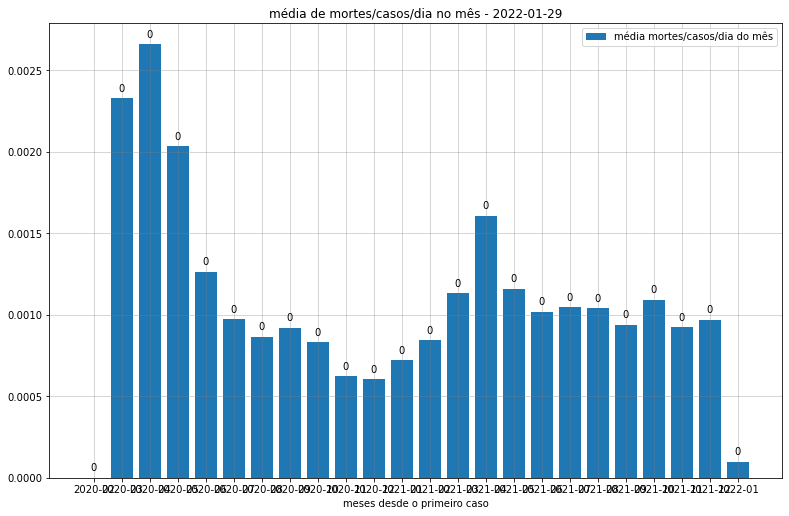

In [29]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(20, 20))
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig, ((ax2)) = plt.subplots(1,1, figsize=(12, 8))
fig.tight_layout(pad=5.0)

ax2.set_title("média de mortes/casos/dia no mês - " + str(df.date.max().date()))
ax2.set_xlabel("meses desde o primeiro caso")
ax2.grid(color='gray', alpha = 0.4)

ax2.bar(df2.index, df2['deaths/cases'], label='média mortes/casos/dia do mês')
#ax2.bar(df2.index, df2.death_day, label='média caso/dia do mês')
#ax2.plot(df2.index, df2['deaths/cases_day_mean'],  label='média acum. moretes/casos/dia/mês', color='red')

for p in ax2.patches:
    ax2.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
ax2.legend()
fig.savefig('../analysis/temp.png')

KeyError: 'deaths_mean'

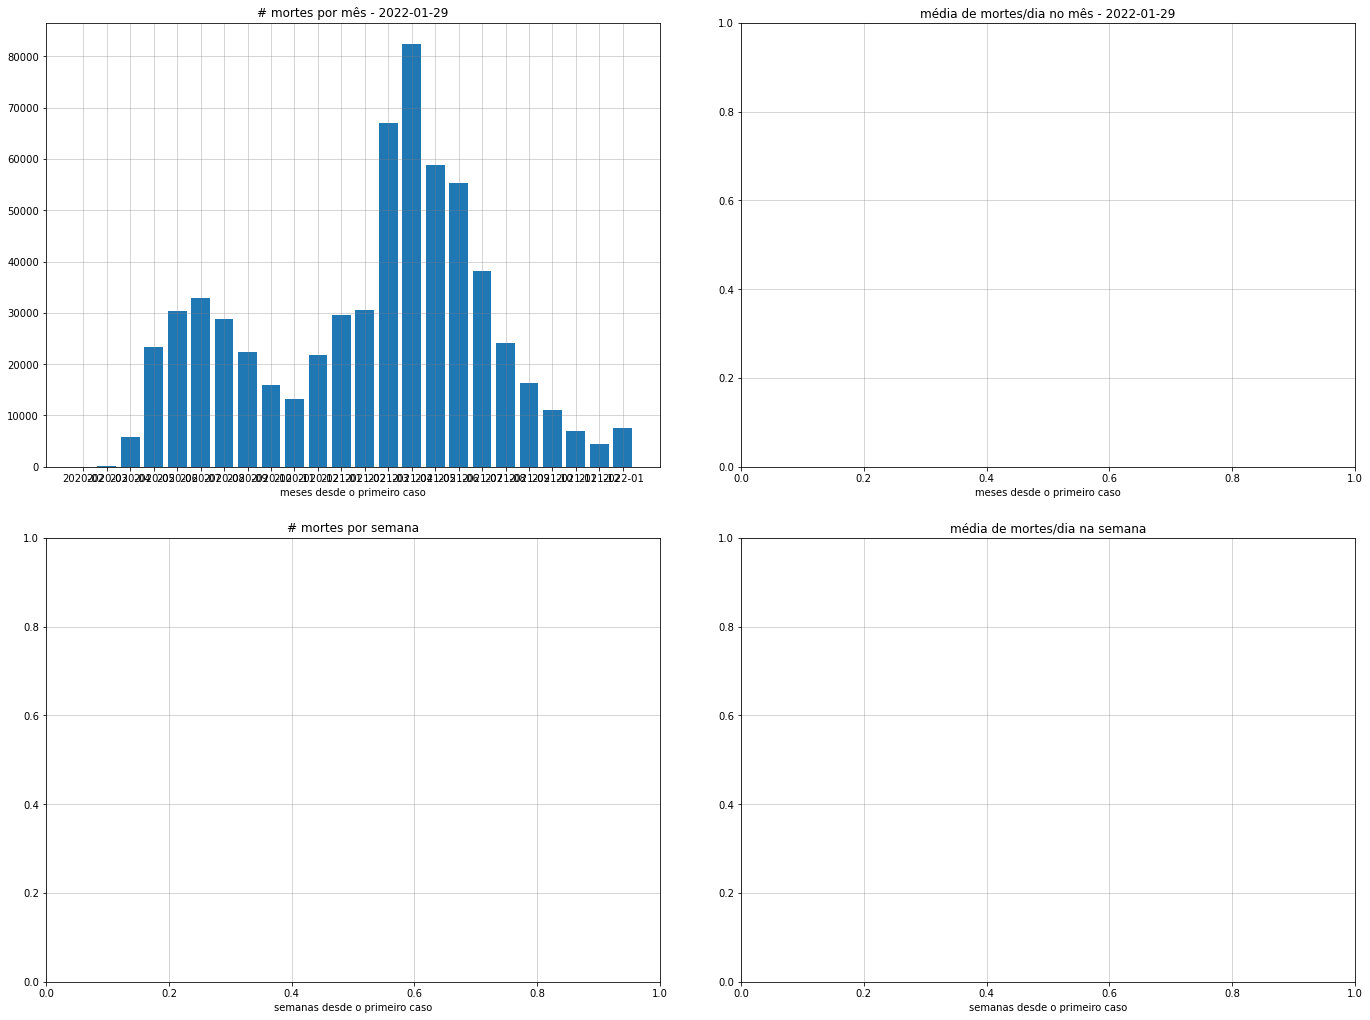

In [12]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(20, 20))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

ax1.set_title("# mortes por mês - " + str(df.date.max().date()))
ax1.set_xlabel("meses desde o primeiro caso")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("média de mortes/dia no mês - " + str(df.date.max().date()))
ax2.set_xlabel("meses desde o primeiro caso")
ax2.grid(color='gray', alpha = 0.4)

ax3.set_title("# mortes por semana")
ax3.set_xlabel("semanas desde o primeiro caso")
ax3.grid(color='gray', alpha = 0.4)

ax4.set_title("média de mortes/dia na semana")
ax4.set_xlabel("semanas desde o primeiro caso")
ax4.grid(color='gray', alpha = 0.4)


ax1.bar(df2.index, df2.deaths, label='mortes no mês')
ax1.plot(df2.index, df2['deaths_mean'],  label='média acum. mortes/mês', color='red')
# ax1.plot(df2.index, df2['deaths_mean'],  label='%', color='green', secondary_y=True, ax=ax)

ax1y = ax1.twinx()
# ax1y.set_ylabel('% var.', color='purple')  # we already handled the x-label with ax1
# ax1y.plot(df2.index, df2['perc_var_deaths'], color='purple')
# ax1y.tick_params(axis='y', labelcolor='purple')
for p in ax1.patches:
    ax1.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    

ax2.bar(df2.index, df2.death_day, label='média morte/dia do mês')
ax2.plot(df2.index, df2['death_day_mean'],  label='média acum. mortes/dia/mês', color='red')

for p in ax2.patches:
    ax2.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
ax3.bar(df3.index, df3.deaths, label='mortes na semana')
ax3.plot(df3.index, df3['deaths_mean'],  label='média acum. mortes/dia/mês', color='red')

# ax4.bar(df3.index, df3.death_day, label='média morte/dia na semana')
ax4.plot(df3.index, df3['deaths'],  label='média acum. mortes/dia da semana', color='red')


# for index, value in enumerate(df2.death_day):
# #     ax2.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
#     ax2.annotate(value, index, str(value))
    

# ax2.plot(dados.day, dados.avg7_cases, label = state)
# ax3.plot(dados.day, dados.deaths, label = state)
# ax4.plot(dados.day, dados.avg7_deaths, label = state)
#     ax5.plot(df[indexes].day, df[indexes].recoveries, label = state)
#     ax6.plot(df[indexes].day, df[indexes].avg7_recoveries, label = state)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
# ax5.legend()
# ax6.legend()
# fig.savefig('../analysis/temp.png')

In [ ]:
df[df.state=='SP'].tail(10)

In [ ]:
# for state in df.state.unique():
#     index  = ((df.state==state) & (df.is_last == True))
#     print(df[index].state, df[index].date, df[index].yearWeek.values)

In [ ]:
state_geo = json.load(open('../data/brasil-estados.json'))
anoMes = str(datetime.datetime.now().year) + '-' + '{:02d}'.format(datetime.datetime.now().month)
df_mapa = df_estados[df_estados.index.get_level_values(0)==anoMes].copy()
states = df_mapa.index.get_level_values(1).unique()

for state in state_geo['features']: 
    latLon =  state['properties']['centroide']
    codarea = state['properties']['codarea']
    df_mapa.loc[df_mapa['city_ibge_code']==int(codarea),'lat'] = latLon[1]
    df_mapa.loc[df_mapa['city_ibge_code']==int(codarea),'lon'] = latLon[0]

df_mapa.tail()

In [ ]:
m = folium.Map(location=[-15.75, -49.95], zoom_start=4)
df_mapa.city_ibge_code = df_mapa.city_ibge_code.astype('str') # para o mappgin

folium.Choropleth(
    geo_data=state_geo,
    name='Mortes por 1000 habitantes no mês',
    data=df_mapa,
    columns=['city_ibge_code', 'deaths_thousand'],
    key_on='feature.properties.codarea',
    fill_color='YlOrRd',#'YlGn',
#     ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name= 'mortes por 1000 habitantes em '+ anoMes,
).add_to(m)

for state in states:
    dados = df_mapa[df_mapa.index.get_level_values(1)==state]
    detalhes = '<center><b>'+dados.index.get_level_values(1).values[0] +'</b></center>\n'
#     detalhes += 'casos: ' + str(dados.cases.sum()) + ', mortes: ' + str(dados.deaths.sum())
    detalhes += ', mortes/k hab: ' + str(dados.deaths_thousand.values[0].round(4))
    
    folium.CircleMarker(
        location=[dados.lat,dados.lon],
        radius=5,
#         popup=detalhes,
        color='#727b7d',
        fill=True,
        fill_color='black',
        tooltip=detalhes,
        icon=folium.Icon(color='blue',
             icon_color='black',
             icon='info-sign',
             prefix='es')
    ).add_to(m)

folium.LayerControl().add_to(m)

m.save('../analysis/maps/brazilMapDeaths.html')
m

In [13]:
df_top = df_estados[df_estados.index.get_level_values(0)==anoMes].sort_values('deaths_thousand', ascending = False)
# df_top['state'] = df_top.index.get_level_values(1)
df_top.reset_index(0, inplace=True)
# df_top.index = df_top.index + 1
# df_top_deaths = df_top_deaths[cols].head(qtdeMonitored)
df_top

NameError: name 'anoMes' is not defined

In [14]:
df[(df['date']=='2021-03-16')].tail()

,date,state,city,place_type,cases,deaths,day,is_last,population,estimated_population,...,yearWeek,diasMes,perc_death,case_day,death_day,cases_thousand,deaths_thousand,case_day_thousand,death_day_thousand,avg7_deaths
15254,2021-03-16,RS,-,state,9331,501,368,False,11377239,11422973.0,...,21-11,31,2.07,9331,501,66.288,1.372,0.820,0.044,252.714286
15933,2021-03-16,SC,-,state,7547,167,370,False,7164788,7252502.0,...,21-11,31,1.21,7547,167,103.402,1.250,1.053,0.023,112.571429
16609,2021-03-16,SE,-,state,516,22,357,False,2298696,2318822.0,...,21-11,31,1.97,516,22,69.767,1.376,0.224,0.010,17.142857
17307,2021-03-16,SP,-,state,17684,679,379,False,45919049,46289333.0,...,21-11,31,2.92,17684,679,48.475,1.413,0.385,0.015,400.142857
17978,2021-03-16,TO,-,state,1165,20,364,False,1572866,1590248.0,...,21-11,31,1.35,1165,20,81.544,1.103,0.741,0.013,17.714286


In [19]:
df

,date,state,city,place_type,cases,deaths,day,is_last,population,estimated_population,...,yearWeek,diasMes,perc_death,case_day,death_day,cases_thousand,deaths_thousand,case_day_thousand,death_day_thousand,avg7_deaths
0,2020-03-17,AC,-,state,3,0,1,False,881935,894470.0,...,20-12,31,0.00,3,0,0.003,0.000,0.003,0.000,0.000000
1,2020-03-18,AC,-,state,0,0,2,False,881935,894470.0,...,20-12,31,0.00,0,0,0.003,0.000,0.000,0.000,0.000000
2,2020-03-19,AC,-,state,1,0,3,False,881935,894470.0,...,20-12,31,0.00,1,0,0.005,0.000,0.001,0.000,0.000000
3,2020-03-20,AC,-,state,3,0,4,False,881935,894470.0,...,20-12,31,0.00,3,0,0.008,0.000,0.003,0.000,0.000000
4,2020-03-21,AC,-,state,4,0,5,False,881935,894470.0,...,20-12,31,0.00,4,0,0.012,0.000,0.005,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17629,2021-12-28,TO,-,state,376,3,622,False,1572866,1590248.0,...,21-52,31,1.67,376,3,149.625,2.502,0.239,0.002,2.142857
17630,2021-12-29,TO,-,state,218,3,623,False,1572866,1590248.0,...,21-52,31,1.67,218,3,149.764,2.504,0.139,0.002,2.428571
17631,2022-01-02,TO,-,state,359,3,624,False,1572866,1590248.0,...,22-52,5,1.67,359,3,149.992,2.506,0.228,0.002,2.714286
17632,2022-01-03,TO,-,state,637,2,625,False,1572866,1590248.0,...,22-01,5,1.67,637,2,150.397,2.508,0.405,0.001,2.714286
